Import libraries

In [2]:
from pathlib import Path 
from monai.data import Dataset
from monai.transforms import (
    AsDiscrete,
    AsDiscreted,
    Compose,
    LoadImaged,
    ToTensord,
    AddChanneld,
    Spacingd,
    ScaleIntensityRanged,
    CropForegroundd, 
    Resized,
    Orientationd,
    Invertd,
    SaveImaged,
    EnsureChannelFirstd)
 
import torch
import random
from monai.networks.nets import UNet
from monai.networks.layers import Norm
from monai.metrics import DiceMetric
from monai.losses import DiceLoss
from monai.inferers import sliding_window_inference
from monai.data import CacheDataset, DataLoader, Dataset, decollate_batch
from monai.config import print_config
from monai.apps import download_and_extract
import torch
import matplotlib.pyplot as plt
import tempfile
import shutil
import os
from glob import glob
from monai.utils import first
import numpy as np
from torch.utils.data import Subset
import nibabel as nib

Paths of kidney images

In [3]:
data_dir = Path('/home/mary/Documents/kidney_ds')

data_subdir_iml = data_dir / "image"/ "left"

data_subdir_imr = data_dir / "image"/ "right"

data_subdir_lbl = data_dir / "label"/ "left"

data_subdir_lbr = data_dir / "label"/ "right"

In [4]:
images_left = sorted(glob(os.path.join(data_subdir_iml, '*.nii.gz')))
images_right = sorted(glob(os.path.join(data_subdir_imr, '*.nii.gz')))
labels_left = sorted(glob(os.path.join(data_subdir_lbl, '*.nii.gz')))
labels_right = sorted(glob(os.path.join(data_subdir_lbr, '*.nii.gz')))

In [5]:
train_files_left = [{"image": image_name, 'label': label_name} for image_name, label_name in zip(images_left, labels_left)]
train_files_right = [{"image": image_name, 'label': label_name} for image_name, label_name in zip(images_right, labels_right)]

Monai transormers

In [6]:
train_transforms = Compose(
    [
        LoadImaged(keys=['image', 'label']),
        #add channels to the images that monai can interpret in this way
        AddChanneld(keys=['image', 'label']),
        #rescale the voxels pixdim=(height,width,depth) 
        Spacingd(keys=['image', 'label'], pixdim=(1.5, 1.5, 2)),
        Orientationd(keys=['image', 'label'], axcodes="RAS"),
        ScaleIntensityRanged(keys='image', a_min=-100, a_max=1000, b_min=0.0, b_max=1.0, clip=True),
        Resized(keys=['image', 'label'], spatial_size=[128, 128, 128]),
        #to tensor should be the last transform
        ToTensord(keys=['image', 'label'])
    ]
)


In [7]:
train_ds_left = Dataset(data=train_files_left, transform=train_transforms)
train_ds_right = Dataset(data=train_files_right, transform=train_transforms)

Making a class that takes left images and right images.
Concatenate them on channel dimension

In [8]:
class Data_Single(Dataset):

    def __init__(self, im_dataset_l, im_dataset_r):
        self.im_dataset_l = im_dataset_l
        self.im_dataset_r = im_dataset_r

    def __len__(self):
        return len(self.im_dataset_l)

    def __getitem__(self, index):
        if type(index) is not int:
            if type(index) is not np.int64:
                raise ValueError(f"Need `index` to be `int`. Got {type(index)}.")
        if type(index) is np.int64:
            index = index.item()
            
                    
        img1 = self.im_dataset_l[index]['image']
        img2 = self.im_dataset_r[index]['image']
        
        lbl1 = self.im_dataset_l[index]['label']
        lbl2 = self.im_dataset_r[index]['label']
        
        img = torch.cat((img1,img2),0)
        lbl = torch.cat((lbl1,lbl2),0)
        
        return img, lbl

In [9]:
our_dataset = Data_Single(train_ds_left, train_ds_right)

Check dataloader and try to plot one slice that has tumor from dataloader 

In [10]:
check_loader = DataLoader(our_dataset, batch_size=2)
check_data = first(check_loader)
#in check_data first elemnt is for image or label second is for number of batch
#third is for input channel, forth is width , fifth is height and sixth is 
image, label = (check_data[0][0][0], check_data[1][0][0])

listofslice = []

for counter1 in range(128):
    for counter2 in range(128):
        for counter3 in range(128):
            if label[counter1][counter2][counter3] == 1:
                listofslice.append(counter3)
listofslice = np.unique(listofslice)
slice_nummber = random.choice(listofslice)
slice_nummber

62

In [11]:
print(check_data[0].shape)

torch.Size([2, 2, 128, 128, 128])


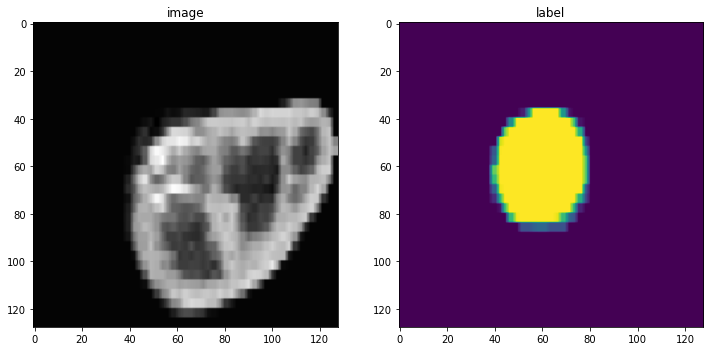

In [12]:
plt.figure("check", (12, 6))
plt.subplot(1, 2, 1)
plt.title("image")
plt.imshow(image[:, :, slice_nummber], cmap="gray")
plt.subplot(1, 2, 2)
plt.title("label")
plt.imshow(label[:, :, slice_nummber])
plt.show()


Choose random numbers for making train, test and validation datasets

In [13]:
random_train = np.random.randint(300, size= int(0.6*len(our_dataset)))

random_val = np.zeros(int(0.2*len(our_dataset)),dtype=np.int64)

random_test = np.zeros(int(0.2*len(our_dataset)),dtype=np.int64)

for i in range(len(random_val)):
    number_val = np.random.randint(300, size=1)
    for number_val in random_train:
        number_val = np.random.randint(300, size=1)
    random_val[i] = number_val    

for j in range(len(random_test)):
     number_test = np.random.randint(300, size=1)
     for number_test in random_train:
         number_test = np.random.randint(300, size=1)
         for number_test in random_val:
            number_test = np.random.randint(300, size=1)
     random_test[j] = number_test  

Making Sub datas

In [14]:
sub_traindata = Subset(our_dataset, random_train)
sub_valdata = Subset(our_dataset, random_val)
sub_testdata = Subset(our_dataset, random_test)

Making Dataloaders

In [15]:
train_loader = DataLoader(sub_traindata, batch_size = 10, shuffle=False)
val_loader = DataLoader(sub_valdata, batch_size = 10, shuffle=False)
test_loader = DataLoader(sub_testdata, batch_size = 10, shuffle=False)

Directiry for saving model

In [16]:
root_dir = Path('/home/mary/Documents/kidney_ds/codes')

Model for segmentation

In [17]:
device = torch.device("cuda:0")
model = UNet(
    spatial_dims=3,
    in_channels=2,
    out_channels=2,
    channels=(64, 128, 256, 512, 1024),
    strides=(2, 2, 2, 2),
    num_res_units=2,
    norm=Norm.BATCH,
).to(device)


In [19]:
from torchsummary import summary
summary(model)

Layer (type:depth-idx)                        Param #
├─Sequential: 1-1                             --
|    └─ResidualUnit: 2-1                      --
|    |    └─Sequential: 3-1                   114,434
|    |    └─Conv3d: 3-2                       3,520
|    └─SkipConnection: 2-2                    --
|    |    └─Sequential: 3-3                   76,738,318
|    └─Sequential: 2-3                        --
|    |    └─Convolution: 3-4                  6,919
|    |    └─ResidualUnit: 3-5                 110
Total params: 76,863,301
Trainable params: 76,863,301
Non-trainable params: 0


Layer (type:depth-idx)                        Param #
├─Sequential: 1-1                             --
|    └─ResidualUnit: 2-1                      --
|    |    └─Sequential: 3-1                   114,434
|    |    └─Conv3d: 3-2                       3,520
|    └─SkipConnection: 2-2                    --
|    |    └─Sequential: 3-3                   76,738,318
|    └─Sequential: 2-3                        --
|    |    └─Convolution: 3-4                  6,919
|    |    └─ResidualUnit: 3-5                 110
Total params: 76,863,301
Trainable params: 76,863,301
Non-trainable params: 0

In [21]:
model.Layer[0]

AttributeError: 'UNet' object has no attribute 'Layer'

Loss function, optimizer and dice metric

In [26]:
loss_function = DiceLoss(to_onehot_y=False, sigmoid=True)
optimizer = torch.optim.Adam(model.parameters(), 1e-4)
dice_metric = DiceMetric(include_background=True, reduction="mean")

Training the model

In [27]:

max_epochs = 600
val_interval = 1
best_metric = -1
best_metric_epoch = -1
epoch_loss_values = []
metric_values = []


post_pred = Compose([AsDiscrete(argmax=True, to_onehot=None)])
post_label = Compose([AsDiscrete(to_onehot=None)])

for epoch in range(max_epochs):
    print("-" * 10)
    print(f"epoch {epoch + 1}/{max_epochs}")
    model.train()
    epoch_loss = 0
    step = 0
    for batch_data in train_loader:
        step += 1
        inputs, labels = (
            batch_data[0].to(device),
            batch_data[1].to(device)    
        )
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = loss_function(outputs, labels)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
        print(f"{step}/{len(our_dataset) // train_loader.batch_size}, "
              f"train_loss: {loss.item():.4f}")
    epoch_loss /= step
    epoch_loss_values.append(epoch_loss)
    print(f"epoch {epoch + 1} average loss: {epoch_loss:.4f}")

    if (epoch + 1) % val_interval == 0:
        model.eval()
        with torch.no_grad():
            for val_data in val_loader:
                val_inputs, val_labels = (
                    val_data[0].to(device),
                    val_data[1].to(device),
                )
                roi_size = (160, 160, 160)
                sw_batch_size = 4
                val_outputs = sliding_window_inference(val_inputs, roi_size, sw_batch_size, model)
                val_outputs = [post_pred(i) for i in decollate_batch(val_outputs)]
                print(val_outputs.shape)
                val_labels = [post_label(i) for i in decollate_batch(val_labels)]
                print(val_labels.shape)
                # compute metric for current iteration
                dice_metric(y_pred=val_outputs, y=val_labels)

            # aggregate the final mean dice result
            metric = dice_metric.aggregate().item()
            # reset the status for next validation round
            dice_metric.reset()

            metric_values.append(metric)
            if metric > best_metric:
                best_metric = metric
                best_metric_epoch = epoch + 1
                torch.save(model.state_dict(), os.path.join(
                    root_dir, "best_metric_model.pth"))
                print("saved new best metric model")
            print(
                f"current epoch: {epoch + 1} current mean dice: {metric:.4f}"
                f"\nbest mean dice: {best_metric:.4f} "
                f"at epoch: {best_metric_epoch}"
            )
            
print(
    f"train completed, best_metric: {best_metric:.4f} "
    f"at epoch: {best_metric_epoch}")

----------
epoch 1/600
1/30, train_loss: 0.8234
2/30, train_loss: 0.8568
3/30, train_loss: 0.8381
4/30, train_loss: 0.7992
5/30, train_loss: 0.8145
6/30, train_loss: 0.8107
7/30, train_loss: 0.7925
8/30, train_loss: 0.8308
9/30, train_loss: 0.8096
10/30, train_loss: 0.8482
11/30, train_loss: 0.8309
12/30, train_loss: 0.8122
13/30, train_loss: 0.8761
14/30, train_loss: 0.8099
15/30, train_loss: 0.8564
16/30, train_loss: 0.8576
17/30, train_loss: 0.8676
18/30, train_loss: 0.8555
epoch 1 average loss: 0.8328


ValueError: y_pred and y should have same shapes.